# Dark Matter Models

Currently the main focus of this code is the introduction of a full model based approach to looking for dark matter. In this tutorial we go through how dark matter models can be used within the package and how to introduce your own.

In this package we assume that the spatial/angular distribution and energy distribution of gamma rays produced from dark matter are independent. Each is developed independently then combined with either the `TwoCompPrior` class or the `CombineDMComps` class which are effectively equivalet but the `CombineDMComps` class has a method to turn the dark matter parameters into the total thermal relic cross-section. We will start with the simpler use case: the spatial distribution/dark matter density profiles.

## Spatial

### `DM_Profile`

All angular distributions for dark matter are currently derivatives of the base class `DM_Profile` which takes a function which calculates the log of the profile as a function of radii and allows various methods and behaviours to then be used. In particular the calculation of the log of the differential J factor, $dJ/d\Omega$. I will detail the various inputs below.

### Inputs

    log_profile_func (callable): Function to compute the log density profile as a function of radius.

    LOCAL_DENSITY (float, optional): Local dark matter density, defaulting to 0.39 GeV/cm^3=3.9 x 10^4 (For consistency, all energy measurements are in TeV in this repo).
    
    dist_to_source (float, optional): Distance to the dark matter source in kpc, defaulting to 8.33 kpc (8.33).

    annihilation (bool, optional): Indicates if the profile is for annihilation (True) or decay (False).
    
    default_rho_s (float, optional): Scale density for the profile, defaulting to 1.0.
    
    default_r_s (float, optional): Scale radius for the profile in kpc, defaulting to 28.4 kpc (28.4).
    
    angular_central_coords (np.ndarray, optional): Central coordinates in galactic coordinates for the profile. Defaults to array([0,0])
    
    kwd_profile_default_vals (dict, optional): Default keyword arguments for the profile calculation.

### Methods

The base class has two public use methods: `logdiffJ`, `scale_density_profile` and `mesh_efficient_logfunc`.

#### `logdiffJ`

For most purposes, `logdiffJ` just takes in a galactic longitude and galactic latitude and outputs the natural log of the differential J factor for the given profile at those coordinates. For example if we use the Einasto profile as an example where the density at a given radius is proportial to $\exp \left(-\frac{2}{\alpha} \left[ \left(\frac{r}{r_s}\right)^\alpha -1\right]\right)$. This is also the function that is called when you use the class as a callable function, e.g. `profile_instance(0.0, 0.0)`

In [1]:
from gammabayes.dark_matter.density_profiles import Einasto_Profile
import numpy as np



log_diffJ_einasto = Einasto_Profile(dist_to_source=8.33,
                               LOCAL_DENSITY=3.3e-4,
                               default_alpha=0.17,
                               default_r_s=28.44,
                               default_rho_s=3.3e-4
                               )

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And evaluate it around the galactic centre in TeV/cm^3 at a slice of 0 latitude.

In [2]:
longitudes = np.linspace(-4,4,1600)
latitudes = 0.0

longitude_mesh, latitude_mesh = np.meshgrid(longitudes, latitudes, indexing='ij')

log_diffJ_einasto_gc_vals = log_diffJ_einasto(
    longitude_mesh.flatten(), 
    latitude_mesh.flatten(),
    kwd_parameters={"r_s":28.44})

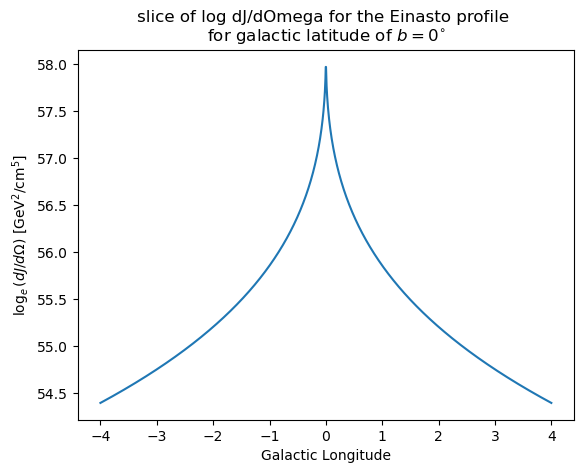

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.title(r'''slice of log dJ/dOmega for the Einasto profile 
for galactic latitude of $b=0^{\circ}$''')
plt.plot(longitudes, log_diffJ_einasto_gc_vals+2*np.log(1e3))
plt.ylabel(r'$\log_e(dJ/d\Omega)$ [GeV$^2$/cm$^5$]')
plt.xlabel("Galactic Longitude")
plt.show()

Or for a linear scale

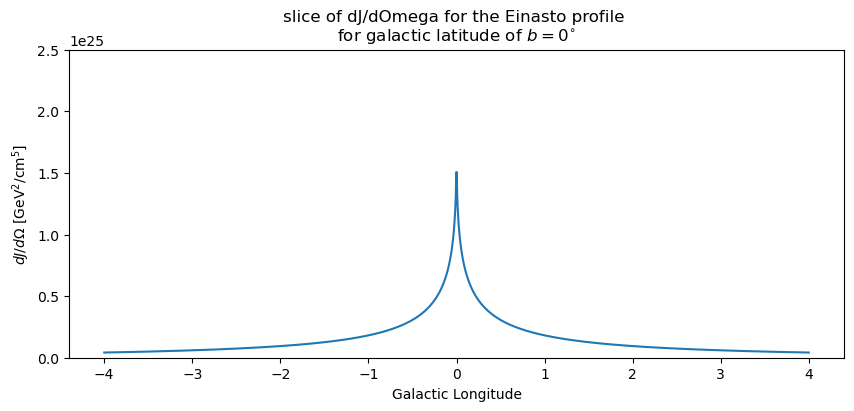

In [4]:
plt.figure(figsize=(10,4))
plt.title(r'''slice of dJ/dOmega for the Einasto profile 
for galactic latitude of $b=0^{\circ}$''')
plt.yscale('linear')
plt.plot(longitudes, np.exp(log_diffJ_einasto_gc_vals)*1e6)
plt.ylabel(r'$dJ/d\Omega$ [GeV$^2$/cm$^5$]')
plt.xlabel("Galactic Longitude")
plt.ylim([0,2.5e25])

plt.show()


#### `log_density`

We then have the method `log_density` which outputs the log of the profile as a function of radius (in kpc) from the centre of the given soruce.

Example for the Einasto profile around the Galactic Centre.

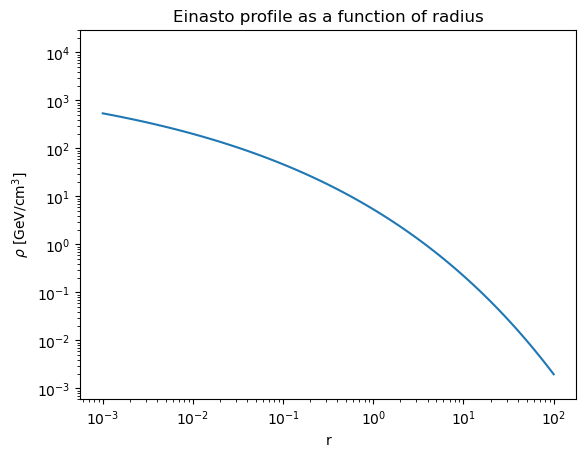

In [5]:
radii = np.logspace(-3, 2, 100)
from astropy import units as u
plt.figure()
plt.title(r'''Einasto profile as a function of radius''')
plt.plot(radii, log_diffJ_einasto.gammapy_profile(radii*u.kpc)*1e3)
plt.ylabel(r'$\rho$ [GeV/cm$^3$]')
plt.xlabel(r"r")
plt.loglog()
plt.ylim([6e-4, 3e4])
plt.show()

#### `scale_density_profile`

The next method simply rescales a given profile based on the default local density you give it. This will re-write the required parameter `rho_s` in evaluations, typically taken as a constant of proportionality, to match the provided local density.

#### `mesh_efficient_logfunc`

The `mesh_efficient_logfunc` is designed particularly for analyses where you want to generate a range of values for a two component model, and want to reduce memory consumption and number of function evaluations by only creating mesh grids of the parameters and observation variables axes for only each relevant component. 

e.g. You may not want/need to create a mesh of parameters of energy, longitude, latitude, dark matter mass, dark matter higgs coupling, einasto profile alpha parameter and the einasto profile scale radius as the size could be huge depending on the resolution of the axes. So instead we create two mesh grids: one for energy and the relevant spectral parameters (mass and coupling) and another for the given longitude, latitude and spatial parameters. 

Then we combine the results at the end rather than having to evaluate the each component on a full grid, you just evaluate it on grids where you get unique output values for that component!







### Native Models

Some popular examples of dark matter density profiles are available in the `GammaBayes` package natively through the `dark_matter.density_profiles` module. They are the Einasto, generalised NFW, Burkert and Moore profiles. We will plot them all against each other for a demonstration.

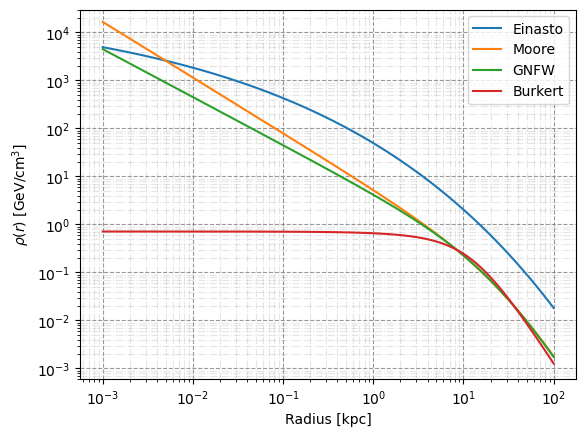

In [6]:
from gammabayes.dark_matter.density_profiles import *
from astropy import units as u
radii = np.logspace(-3,2,100)

plt.figure()
plt.plot(radii, np.exp(Einasto_Profile(
    LOCAL_DENSITY=3e-4, 
    dist_to_source=8.33, 
    default_rho_s=3.e-4
    ).log_density(radii))*1e3, label='Einasto')
plt.plot(radii, np.exp(Moore_Profile(
    LOCAL_DENSITY=3e-4, 
    dist_to_source=8.33, 
    default_rho_s=1.05e-4).log_density(radii))*1e3, label='Moore')
plt.plot(radii, np.exp(GNFW_Profile(
    LOCAL_DENSITY=3e-4, 
    dist_to_source=8.33, 
    default_rho_s=1.84e-4).log_density(radii))*1e3, label='GNFW')
plt.plot(radii, np.exp(Burkert_Profile(
    LOCAL_DENSITY=3e-4, 
    dist_to_source=8.33, 
    default_rho_s=7.12e-4).log_density(radii))*1e3, label='Burkert')
plt.loglog()
plt.legend()
plt.ylabel(r'$\rho(r)$ [GeV/cm$^3$]')
plt.xlabel("Radius [kpc]")
plt.ylim([6e-4, 3e4])
plt.grid(ls='--', axis='both', c='grey', alpha=0.8, which='major')
plt.grid(ls='-.', axis='both', c='grey', alpha=0.2, which='minor')
plt.show()

## Spectral

Now for the fun bit. `GammaBayes` currently only natively supports the use of dark matter models with continuous spectra, i.e. non-line emission models. It currently natively supports single channel spectra, where you assume that dark matter annihilates into a particular channel and try to iobserve that over the background for example, and the Z2 real scalar singlet dark matter model.

We will start with the general `DM_ContinuousEmission_Spectrum` class which one can use to produce the prior for any model if given a range of annihilation or branching ratios to interpoalte on.

### `DM_ContinuousEmission_Spectrum`

I will first provide the inputs.

### Inputs

    annihilation_fractions (dict): A dictionary mapping dark matter annihilation channels to their respective fraction of total annihilation events. This parameter defines the contribution of each channel to the overall annihilation spectrum.
    
    parameter_interpolation_values (dict | list): A structure specifying the parameter values over which interpolation should be performed. If a dictionary, keys should match the expected parameter names (e.g., 'mass'), with values being arrays of parameter values. If a list, it is expected to contain arrays of parameter values directly, assuming the order matches `parameter_names` if provided.
    
    ratios (bool, optional): Indicates whether the provided annihilation fractions are to be interpreted as ratios (True) or absolute values (False). When True, fractions will be normalized to sum to 1 across all channels. Defaults to True.
    
    default_parameter_values (dict, optional): A dictionary specifying default values for any parameters required for generating the spectrum but not included in `parameter_interpolation_values`. This could include parameters like 'mass' if not otherwise specified.
    
    parameter_names (list, optional): An optional list of parameter names corresponding to the arrays provided in `parameter_interpolation_values` when it is a list. This is used to ensure proper mapping of values to parameters during interpolation. If `parameter_interpolation_values` is a dictionary, this argument is ignored.


If no inputs are given then the model defaults to the single channel W spectrum.

### Behaviours

This class basically just has one 'behaviour' in that it can be used as a function to output the log of the _unnormalised_ spectra. Unnormalised as it isn't required to put in the partial annihilation cross sections or branching fractions, however, if you give these values then the spectrum should be correct up to the resolution of the interpolation of the relevant values.

To give an example of this we will plot the spectrum of various channels by giving the class various 'dummy' dictionaries where one of the annihilation ratios/branching fractions is one for all values of mass.

In [7]:
from gammabayes.dark_matter import DM_ContinuousEmission_Spectrum
from gammabayes.dark_matter.channel_spectra import (
    PPPCReader, 
)
mass_vec = np.logspace(-3,2,501)
annihilation_dicts = {}
for channel in PPPCReader.darkSUSY_to_PPPC_converter:
    annihilation_dicts[channel] = {}
    for dict_channel in PPPCReader.darkSUSY_to_PPPC_converter:
        if dict_channel!=channel:
            annihilation_dicts[channel][dict_channel] = 0.0*mass_vec
        else:
            annihilation_dicts[channel][dict_channel] = 1.0+0.0*mass_vec

spectrum_class_dict = {channel:
    DM_ContinuousEmission_Spectrum(
        annihilation_fractions=annihilation_dicts[channel],
        parameter_interpolation_values=[mass_vec]) for channel in PPPCReader.darkSUSY_to_PPPC_converter}


-0.7977692462974844
-0.9754038782535588
-0.9913173651727742
-0.6190806597924139
-0.8686487298182666
-1.1070105673881727


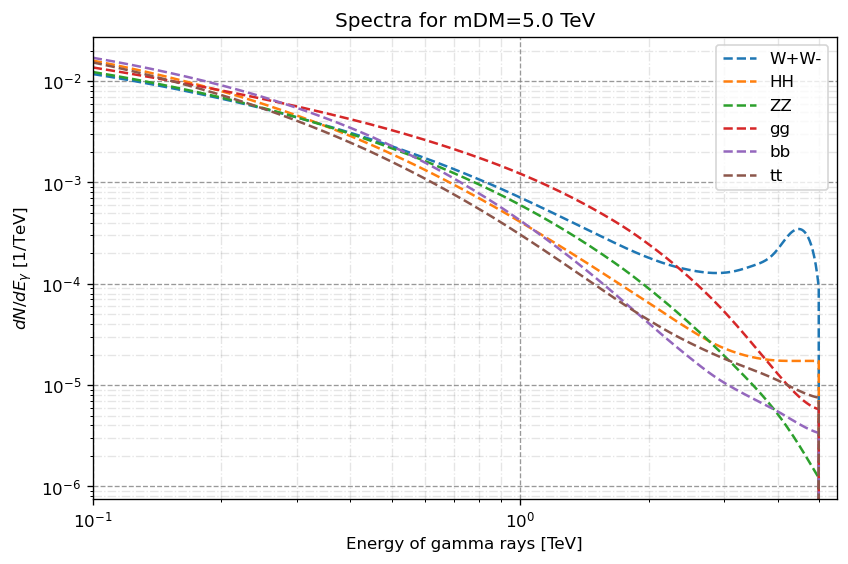

In [8]:
from matplotlib.pyplot import get_cmap
interesting_channels = ['W+W-', 'HH', 'ZZ', 'gg', 'bb', 'tt']
rainbow_map = get_cmap('rainbow')
mDM = 5.0
energy_values = np.logspace(-1,1.1*np.log10(mDM),501)

fig, ax=  plt.subplots(1,1, figsize=(8,5), dpi=120)
plt.title(f"Spectra for mDM={mDM} TeV")
for idx, channel in enumerate(interesting_channels):
    ax.plot(energy_values, 
            np.exp(np.squeeze(spectrum_class_dict[channel].spectral_gen(energy_values, mass=energy_values*0+mDM))), 
            label=channel,
            ls='--'
            # c=rainbow_map(idx/len(interesting_channels))
            )
    print(logspace_riemann(logy=np.squeeze(spectrum_class_dict[channel].spectral_gen(energy_values, mass=energy_values*0+mDM)),
                           x=energy_values))
ax.loglog()
ax.legend()
# ax.set_ylim([1e-1, 1e3])
ax.set_xlim([1e-1, 1.1*mDM])
plt.grid(ls='--', axis='both', c='grey', alpha=0.8, which='major')
plt.grid(ls='-.', axis='both', c='grey', alpha=0.2, which='minor')
plt.ylabel(r'$dN/dE_\gamma$ [1/TeV]')
plt.xlabel(r'Energy of gamma rays [TeV]')
plt.show()

If one wants to produce the spectrum for a full dark matter model, one must provide a matrix of annihilation ratios or branching fractions and the axes which were evaluated on to get these values. To be clear not the mesh of values, but the unique values. We can show how to do this with data available through the package you have installed (hopefully).

In the `dark_matter.spectral_models` module there is another module called `Z2_ScalarSinglet` which holds a natively support class for the Z2 real scalar singlet dark matter model. We can show how this class was created here to demonstrate how you can do this yourself.

Within the module is a csv file which contains the annihilation ratios for this class under `annihilation_ratio_data/annihilation_ratios__darkSUSY.csv`. This csv contains an array of annihilation ratios for the dark matter model produced by the code `darkSUSY`. There is a handy class within the package which you do not have to use, but allows extracting CSVs in the format of this file into a usable dictionary-like object.

The first two columns are the dark matter parameter values used to generate the row of annihilation ratios. We will extract the unique values to get the relevant parameter axes, converting the mass values from GeV to TeV. Then deleting these items from the dictionary.

In [9]:
from gammabayes.dark_matter.spectral_models import CSVDictionary
from gammabayes.dark_matter.spectral_models.Z2_ScalarSinglet.SS_DM_Spectral_Class import ScalarSinglet_Folder_Path




darkSUSY_SS_BFs_cleaned_dict = CSVDictionary(ScalarSinglet_Folder_Path+'/annihilation_ratio_data/annihilation_ratios__darkSUSY.csv', delimiter=' ')

mass_axis, lahS_axis = np.unique(darkSUSY_SS_BFs_cleaned_dict['mS [GeV]'])/1e3, np.unique(darkSUSY_SS_BFs_cleaned_dict['lahS'])


del darkSUSY_SS_BFs_cleaned_dict['mS [GeV]']
del darkSUSY_SS_BFs_cleaned_dict['lahS']


# print to have a look
print(f'mass axis: min={mass_axis.min():.3f}, max={mass_axis.max():.3f}, num={len(mass_axis)}') 
print(f'lahS axis: min={lahS_axis.min():.3f}, max={lahS_axis.max():.3f}, num={len(lahS_axis)}') 

mass axis: min=0.010, max=1046.936, num=253
lahS axis: min=0.001, max=10.000, num=202


WE then reshape the remaining entries into a grid where each row represents one mass value and each column one Higgs coupling value.

In [10]:
parameter_interpolation_values = [mass_axis, lahS_axis]
parameter_axes_shape = (mass_axis.size, lahS_axis.size)

for channel in darkSUSY_SS_BFs_cleaned_dict.keys():
    darkSUSY_SS_BFs_cleaned_dict[channel] = darkSUSY_SS_BFs_cleaned_dict[channel].reshape(parameter_axes_shape)


All we then have to do is put this into the above class.

In [11]:
SS_continuous_emission_instance = DM_ContinuousEmission_Spectrum(
        annihilation_fractions=darkSUSY_SS_BFs_cleaned_dict,
        parameter_interpolation_values=parameter_interpolation_values,
        default_parameter_values={'mass':1.0, 'lahS':0.1},
)

And then we can plot the spectrum!

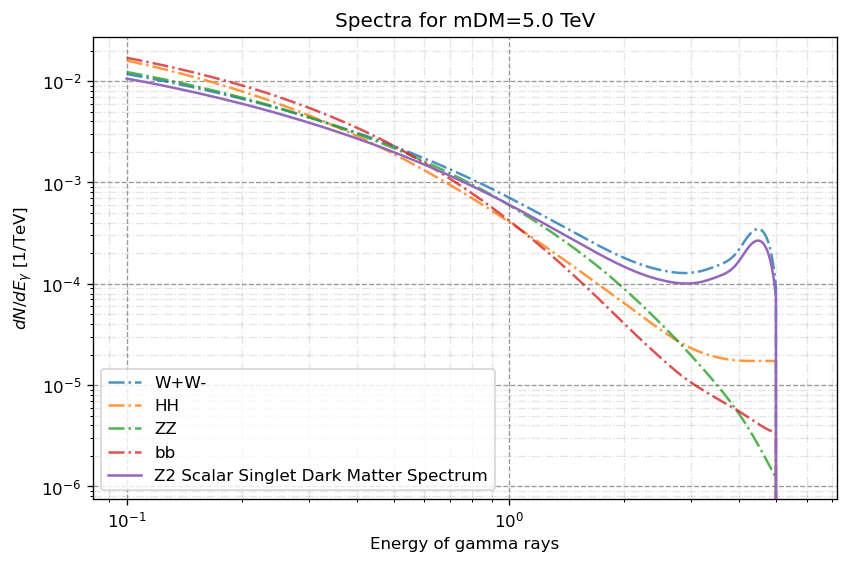

In [12]:
from matplotlib.pyplot import get_cmap
interesting_channels = ['W+W-', 'HH', 'ZZ', 'bb']
rainbow_map = get_cmap('rainbow')

mDM = 5.
energy_values = np.logspace(-1,1.1*np.log10(mDM),501)

fig, ax=  plt.subplots(1,1, figsize=(8,5), dpi=120)

plt.title(f"Spectra for mDM={mDM} TeV")

for idx, channel in enumerate(interesting_channels):
    ax.plot(energy_values, 
            np.exp(np.squeeze(spectrum_class_dict[channel].spectral_gen(energy_values, mass=energy_values*0+mDM))), 
            label=channel,
            alpha=0.8,
            ls='-.'
            # c=rainbow_map(idx/len(interesting_channels))
            )
ax.plot(energy_values, 
            np.exp(np.squeeze(SS_continuous_emission_instance.spectral_gen(energy_values, mass=energy_values*0+mDM))), 
            label='Z2 Scalar Singlet Dark Matter Spectrum',
            # c=rainbow_map(idx/len(interesting_channels))
            )

ax.loglog()
ax.legend()
plt.grid(ls='--', axis='both', c='grey', alpha=0.8, which='major')
plt.grid(ls='-.', axis='both', c='grey', alpha=0.2, which='minor')
plt.ylabel(r'$dN/dE_\gamma$ [1/TeV]')
plt.xlabel(r'Energy of gamma rays')
plt.show()

As previously stated, this model is already natively supported through the `Z2_ScalarSinglet` class.

In [13]:
from gammabayes.dark_matter.spectral_models import Z2_ScalarSinglet

In [14]:
Z2_ScalarSinglet_instance = Z2_ScalarSinglet(ratios=True)

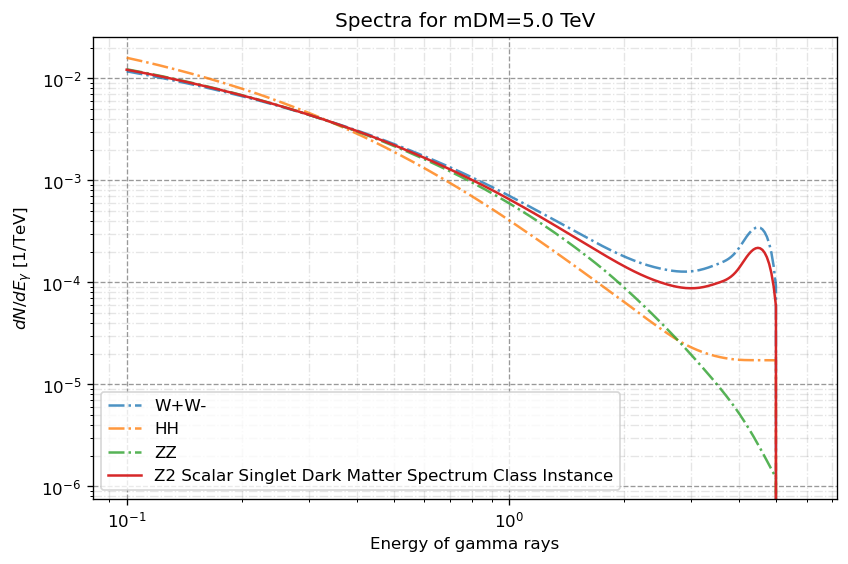

In [15]:
from matplotlib.pyplot import get_cmap
interesting_channels = ['W+W-', 'HH', 'ZZ']
rainbow_map = get_cmap('rainbow')


mDM = 5.0
energy_values = np.logspace(-1,1.1*np.log10(mDM),301)

fig, ax=  plt.subplots(1,1, figsize=(8,5), dpi=120)

plt.title(f"Spectra for mDM={mDM} TeV")

for idx, channel in enumerate(interesting_channels):
    ax.plot(energy_values, 
            np.exp(np.squeeze(spectrum_class_dict[channel].spectral_gen(energy_values, mass=energy_values*0+mDM))), 
            label=channel,
            alpha=0.8,
            ls='-.'
            # c=rainbow_map(idx/len(interesting_channels))
            )


ax.plot(energy_values, 
            np.exp(np.squeeze(Z2_ScalarSinglet_instance.spectral_gen(energy_values, mass=energy_values*0+mDM))), 
            label='Z2 Scalar Singlet Dark Matter Spectrum Class Instance',
            # c=rainbow_map(idx/len(interesting_channels))
            )

ax.loglog()
ax.legend()
plt.grid(ls='--', axis='both', c='grey', alpha=0.8, which='major')
plt.grid(ls='-.', axis='both', c='grey', alpha=0.2, which='minor')
plt.ylabel(r'$dN/dE_\gamma$ [1/TeV]')
plt.xlabel(r'Energy of gamma rays')
plt.show()

# Combining the components

Hey there, thanks for coming through our documentation. This part of the page is still under construction. For references on how this class is used please refer to the `Simulations` or `Hyperparameter Inference with GammaBayes`. If you are having particular issues please raise an issue on the GitHub page, or send me an email at `Liam.Pinchbeck@monash.edu`.